In [1]:
# SGA-2 (Feature Engineering & Model Development)
# Name: Sagnik Dey
# BITS ID: 2023EBCS536
# Dataset: Cleaned Heart Disease Dataset (From Assignment 1)
# ===================================================

# Assumption:
'''
It has been assumed that the cleaned data is loaded and downloaded and the previous code for data processing from the previous SGA-1 Assigment from the code file EDA.ipynb
The code to download is here:
# Saved the cleaned data in the form of a CSV File
df.to_csv("cleaned_heart_disease.csv", index=False)
print("\nCleaned Dataset saved as 'cleaned_heart_disease.csv'")
'''

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LinearRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix, accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Load the cleaned dataset
df = pd.read_csv("cleaned_heart_disease.csv")

# Converts multi-class target into binary classification
df['target'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
df.drop(columns='num', inplace=True)

# Separates features and target
X = df.drop(columns='target')
y = df['target']

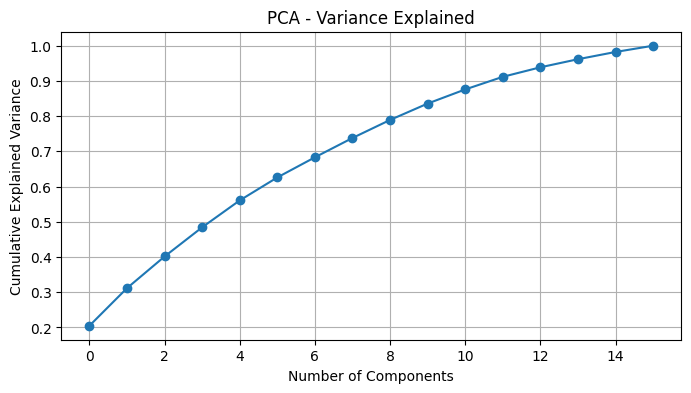

In [2]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Variance Explained')
plt.grid(True)
plt.show()

# Chose 12 number of components that explain ~95% variance as it can be seen from the plot
pca_final = PCA(n_components=12)
X_reduced = pca_final.fit_transform(X_scaled)


In [3]:
# Filter-based method used is ANOVA F-score (SelectKBest)
select_k = SelectKBest(score_func=f_classif, k=12)
X_filter = select_k.fit_transform(X, y)
selected_filter_features = X.columns[select_k.get_support()]
print("Filter-based selected features:", list(selected_filter_features))

# Wrapper method: Recursive Feature Elimination (RFE)
model = LinearRegression()
rfe = RFE(model, n_features_to_select=12)
X_rfe = rfe.fit_transform(X, y)
selected_wrapper_features = X.columns[rfe.support_]
print("Wrapper-based selected features:", list(selected_wrapper_features))


Filter-based selected features: ['age', 'trestbps', 'thalach', 'oldpeak', 'ca', 'sex_1', 'cp_3', 'cp_4', 'restecg_2', 'exang_1', 'slope_2', 'thal_7.0']
Wrapper-based selected features: ['oldpeak', 'ca', 'sex_1', 'cp_3', 'cp_4', 'restecg_1', 'restecg_2', 'exang_1', 'slope_2', 'slope_3', 'thal_6.0', 'thal_7.0']


In [4]:
# Check class balance
print("Class Distribution:")
print(y.value_counts())

# Apply SMOTE if imbalance exists
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Check new distribution
print("Class Distribution After SMOTE:")
print(y_balanced.value_counts())


Class Distribution:
target
0    121
1     62
Name: count, dtype: int64
Class Distribution After SMOTE:
target
1    121
0    121
Name: count, dtype: int64


In [5]:
# Train-test split (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Linear Regression Model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_continuous = lr.predict(X_test)

# Thresholding: Converts predicted values to 0 or 1
y_pred_class = [1 if prob >= 0.5 else 0 for prob in y_pred_continuous]

# Evaluation of the model
print("Linear Regression Evaluation:")
print(confusion_matrix(y_test, y_pred_class))
print(classification_report(y_test, y_pred_class))

# Regression Metrics
mae = mean_absolute_error(y_test, y_pred_continuous)
mse = mean_squared_error(y_test, y_pred_continuous)
r2 = r2_score(y_test, y_pred_continuous)

print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R2 Score: {r2:.3f}")


Linear Regression Evaluation:
[[20  4]
 [ 6 19]]
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        24
           1       0.83      0.76      0.79        25

    accuracy                           0.80        49
   macro avg       0.80      0.80      0.80        49
weighted avg       0.80      0.80      0.80        49

MAE: 0.297
MSE: 0.155
R2 Score: 0.381


Decision Tree Evaluation:
[[21  3]
 [ 5 20]]
              precision    recall  f1-score   support

           0       0.81      0.88      0.84        24
           1       0.87      0.80      0.83        25

    accuracy                           0.84        49
   macro avg       0.84      0.84      0.84        49
weighted avg       0.84      0.84      0.84        49



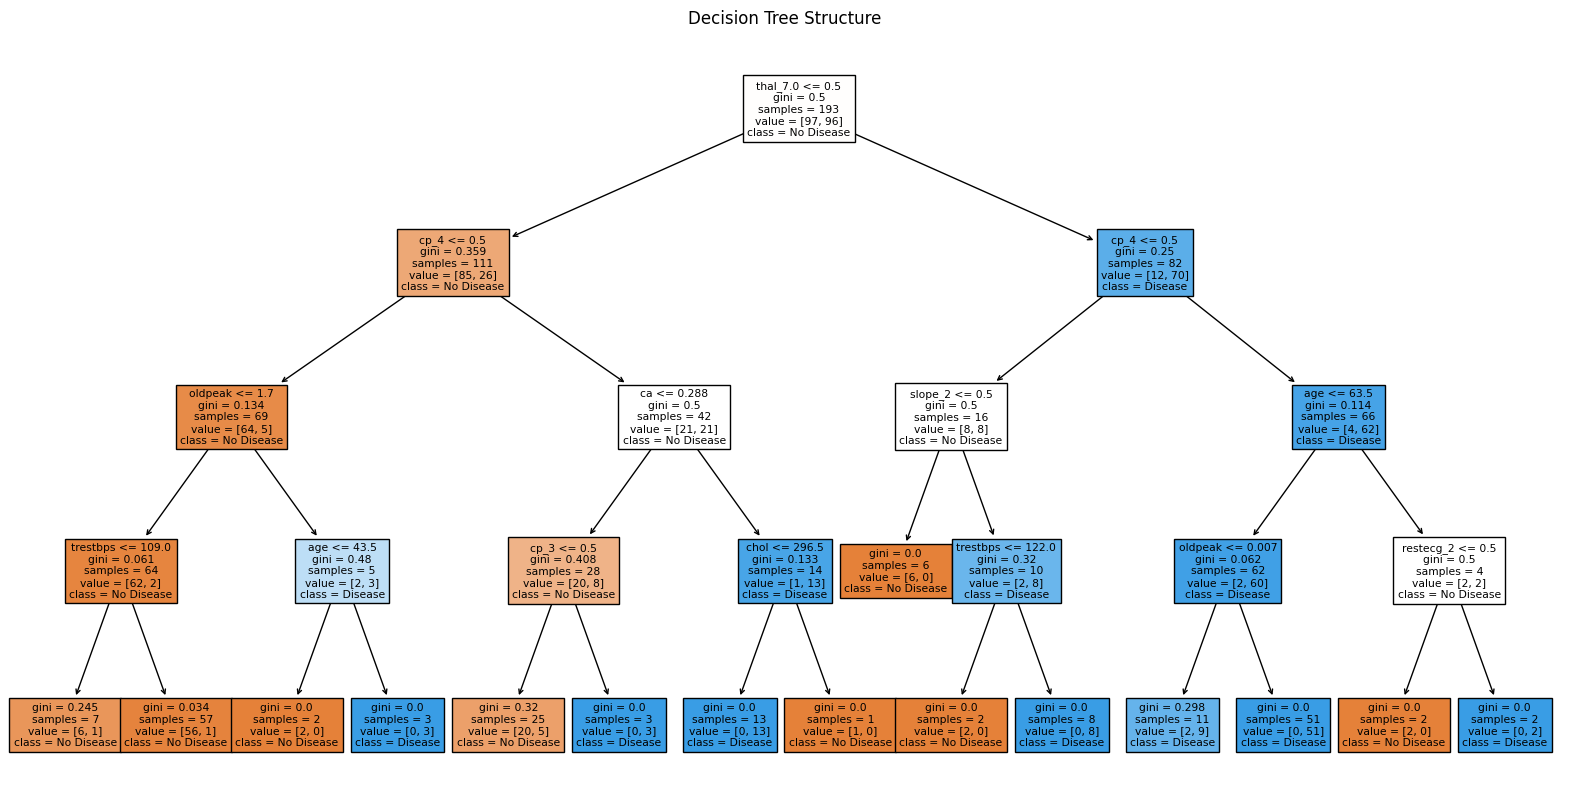

In [6]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

dt = DecisionTreeClassifier(max_depth=4, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("Decision Tree Evaluation:")
print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

# Visualize the tree
plt.figure(figsize=(20,10))
plot_tree(dt, feature_names=X.columns, class_names=['No Disease', 'Disease'], filled=True)
plt.title("Decision Tree Structure")
plt.show()


In [7]:
# Accuracy for Linear Regression (used as classifier)
lr_accuracy = accuracy_score(y_test, y_pred_class)
print(f"Linear Regression Accuracy: {lr_accuracy:.3f}")

# Accuracy for Decision Tree
dt_accuracy = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {dt_accuracy:.3f}")

Linear Regression Accuracy: 0.796
Decision Tree Accuracy: 0.837


In [10]:
def thresholded_accuracy(y_true, y_pred_continuous):
    y_pred = np.where(y_pred_continuous >= 0.5, 1, 0)
    return accuracy_score(y_true, y_pred)

scorer = make_scorer(thresholded_accuracy)

# Perform cross-validation
lr_model = LinearRegression()
lr_scores = cross_val_score(lr_model, X_balanced, y_balanced, cv=5, scoring=scorer)

print(f"Linear Regression: \nMean:{lr_scores.mean():.3f} \nStandard Deviation:{lr_scores.std():.3f}")


# Decision Tree
dt_model = DecisionTreeClassifier(max_depth=4, random_state=42)
dt_scores = cross_val_score(dt_model, X_balanced, y_balanced, cv=5, scoring=make_scorer(accuracy_score))
print(f"Decision Tree: \nMean:{dt_scores.mean():.3f} \nStandard Deviation:{dt_scores.std():.3f}")


Linear Regression: 
Mean:0.831 
Standard Deviation:0.077
Decision Tree: 
Mean:0.847 
Standard Deviation:0.076
